# Lab 5 — DBSCAN on Global Finance


In [1]:

# === Imports & Settings ===
import os, re, glob, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

from IPython.display import display

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.dpi'] = 120

print('Versions -> numpy', np.__version__, '| pandas', pd.__version__)


Versions -> numpy 2.0.2 | pandas 2.2.2


## 1) Загрузка данных

In [2]:

# Colab-friendly upload block
fname = None
try:
    from google.colab import files  # type: ignore
    print("Upload 'Global finance data.csv' (или аналогичный)")
    uploaded = files.upload()
    if uploaded:
        fname = list(uploaded.keys())[0]
except Exception as e:
    print("files.upload() недоступен. Попробуем найти файл локально.")

if fname is None:
    patterns = [r".*global.*finance.*\.csv$", r".*finance.*global.*\.csv$"]
    candidates = []
    for path in glob.glob("*.csv") + glob.glob("/content/*.csv") + glob.glob("/mnt/data/*.csv"):
        name = os.path.basename(path).lower()
        for p in patterns:
            if re.match(p, name):
                candidates.append(path); break
    fname = candidates[0] if candidates else "Global finance data.csv"

def robust_read_csv(path):
    for enc in ("utf-8", "cp1251", "latin1"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    return pd.read_csv(path)

df = robust_read_csv(fname)
print("Loaded:", fname, "| shape:", df.shape)
display(df.head(3))
display(df.info())
display(df.describe(include='all').transpose().head(20))


Upload 'Global finance data.csv' (или аналогичный)


Saving Global finance data.csv to Global finance data.csv
Loaded: Global finance data.csv | shape: (39, 26)


,Country,Date,Stock_Index,Index_Value,Daily_Change_Percent,Market_Cap_Trillion_USD,GDP_Growth_Rate_Percent,Inflation_Rate_Percent,Interest_Rate_Percent,Unemployment_Rate_Percent,...,Commodity_Index,Oil_Price_USD_Barrel,Gold_Price_USD_Ounce,Bond_Yield_10Y_Percent,Credit_Rating,Political_Risk_Score,Banking_Sector_Health,Real_Estate_Index,Export_Growth_Percent,Import_Growth_Percent
0,United States,2024-08-15,S&P_500,5437.2,0.34,51.2,2.8,2.9,5.5,3.7,...,1.12,77.85,2487.5,4.25,AAA,8.1,Strong,145.6,3.2,2.8
1,China,2024-08-15,Shanghai_Composite,2891.6,-0.82,12.4,5.2,0.8,3.1,5.2,...,0.98,77.85,2487.5,2.15,A+,6.7,Moderate,98.7,8.9,6.1
2,Japan,2024-08-15,Nikkei_225,36789.1,1.24,6.8,0.9,2.8,-0.1,2.4,...,1.05,77.85,2487.5,0.89,A+,8.4,Strong,89.3,5.1,4.7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              39 non-null     object 
 1   Date                                 39 non-null     object 
 2   Stock_Index                          39 non-null     object 
 3   Index_Value                          39 non-null     float64
 4   Daily_Change_Percent                 39 non-null     float64
 5   Market_Cap_Trillion_USD              39 non-null     float64
 6   GDP_Growth_Rate_Percent              39 non-null     float64
 7   Inflation_Rate_Percent               39 non-null     float64
 8   Interest_Rate_Percent                39 non-null     float64
 9   Unemployment_Rate_Percent            39 non-null     float64
 10  Currency_Code                        39 non-null     object 
 11  Exchange_Rate_USD                 

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Country,39,39,United States,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,39,1,2024-08-15,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stock_Index,39,39,S&P_500,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Index_Value,39.0,NaN,NaN,NaN,59964.774359,249537.018541,889.3,2711.8,8156.3,23012.25,1567890.2
Daily_Change_Percent,39.0,NaN,NaN,NaN,0.654103,0.834672,-1.23,0.31,0.67,0.89,3.45
Market_Cap_Trillion_USD,39.0,NaN,NaN,NaN,2.912821,8.260615,0.03,0.4,0.7,2.45,51.2
GDP_Growth_Rate_Percent,39.0,NaN,NaN,NaN,2.415385,1.874558,-1.9,1.15,2.4,3.15,6.8
Inflation_Rate_Percent,39.0,NaN,NaN,NaN,11.023077,34.828629,-0.4,1.95,2.8,4.3,211.4
Interest_Rate_Percent,39.0,NaN,NaN,NaN,10.64359,21.866714,-0.1,4.05,4.75,6.5,133.0
Unemployment_Rate_Percent,39.0,NaN,NaN,NaN,5.887179,4.636138,1.2,3.3,5.1,7.3,28.7


## 2) Выбор признаков и предобработка

In [3]:

import unicodedata, re
def normalize(s):
    if s is None: return ""
    s = str(s)
    s = unicodedata.normalize('NFKD', s)
    s = s.encode('ascii', 'ignore').decode('ascii')
    s = s.lower()
    s = re.sub(r"[^a-z0-9]+", "", s)
    return s

preferred_keywords = ["inflation","unemployment","interest","gdpgrowth","gdprate","gdp","debtgdp","governmentdebt","govdebt","debt"]

numeric_df = df.select_dtypes(include=[np.number]).copy()

preferred = []
for c in df.columns:
    cn = normalize(c)
    for kw in preferred_keywords:
        if kw in cn:
            if c in numeric_df.columns:
                preferred.append(c)
            break

if len(preferred) < 3:
    variances = numeric_df.var().sort_values(ascending=False)
    top = [c for c in variances.index if normalize(c) not in ("id","index","idx")]
    selected = list(dict.fromkeys(preferred + top))[:6]
else:
    extra = [c for c in numeric_df.columns if c not in preferred]
    selected = (preferred + extra)[:6]

if len(selected) < 2:
    selected = numeric_df.columns.tolist()[:2]

print("Selected features:", selected)

Xdf = numeric_df[selected].dropna().copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xdf.values)

pca = PCA(n_components=2, random_state=42)
X_vis = pca.fit_transform(X_scaled)
print("PCA explained variance ratio:", pca.explained_variance_ratio_)


Selected features: ['GDP_Growth_Rate_Percent', 'Inflation_Rate_Percent', 'Interest_Rate_Percent', 'Unemployment_Rate_Percent', 'Government_Debt_GDP_Percent', 'Index_Value']
PCA explained variance ratio: [0.51189314 0.17787789]


## 3) Перебор параметров DBSCAN

In [4]:

from itertools import product
def safe_silhouette(X, labels):
    unique = np.unique(labels)
    if len(unique) <= 1:
        return np.nan
    if len([u for u in unique if u != -1]) < 2:
        return np.nan
    return silhouette_score(X, labels)

def safe_dbi(X, labels):
    unique = np.unique(labels)
    if len(unique) <= 1:
        return np.nan
    if len([u for u in unique if u != -1]) < 2:
        return np.nan
    return davies_bouldin_score(X, labels)

eps_grid = np.round(np.linspace(0.1, 1.2, 12), 2)
min_samples_grid = [3, 5, 10, 15]

rows = []
for eps in eps_grid:
    for ms in min_samples_grid:
        model = DBSCAN(eps=eps, min_samples=ms)
        labels = model.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = int(np.sum(labels == -1))
        sil = safe_silhouette(X_scaled, labels)
        dbi = safe_dbi(X_scaled, labels)
        rows.append(dict(eps=eps, min_samples=ms, n_clusters=n_clusters, n_noise=n_noise,
                         silhouette=sil, dbi=dbi))
res_df = pd.DataFrame(rows)
display(res_df.head(10))


,eps,min_samples,n_clusters,n_noise,silhouette,dbi
0,0.1,3,0,39,NaN,NaN
1,0.1,5,0,39,NaN,NaN
2,0.1,10,0,39,NaN,NaN
3,0.1,15,0,39,NaN,NaN
4,0.2,3,0,39,NaN,NaN
5,0.2,5,0,39,NaN,NaN
6,0.2,10,0,39,NaN,NaN
7,0.2,15,0,39,NaN,NaN
8,0.3,3,0,39,NaN,NaN
9,0.3,5,0,39,NaN,NaN


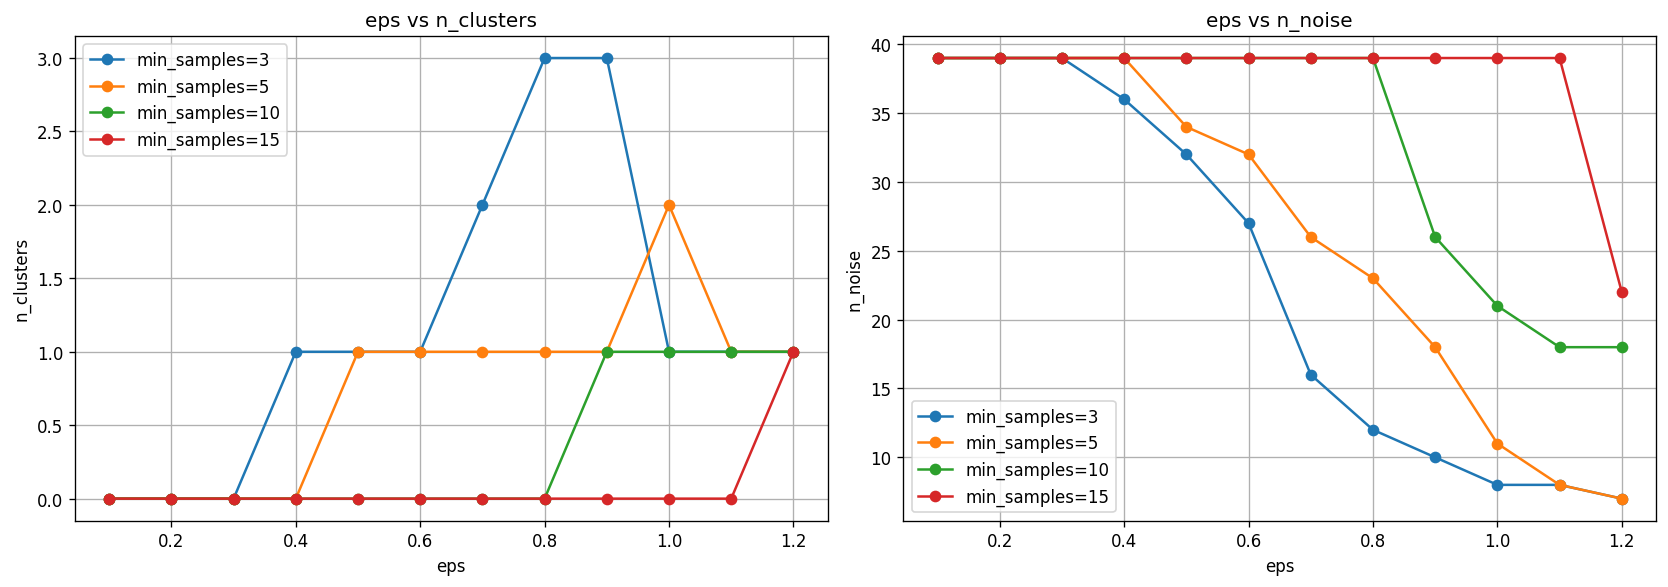

In [5]:

# Графики
fig, axes = plt.subplots(1, 2, figsize=(14,5))

for ms in sorted(res_df['min_samples'].unique()):
    sub = res_df[res_df['min_samples'] == ms]
    axes[0].plot(sub['eps'], sub['n_clusters'], marker='o', label=f"min_samples={ms}")
    axes[1].plot(sub['eps'], sub['n_noise'], marker='o', label=f"min_samples={ms}")

axes[0].set_title("eps vs n_clusters"); axes[0].set_xlabel("eps"); axes[0].set_ylabel("n_clusters"); axes[0].legend()
axes[1].set_title("eps vs n_noise"); axes[1].set_xlabel("eps"); axes[1].set_ylabel("n_noise"); axes[1].legend()
plt.tight_layout(); plt.show()


In [6]:

# Выбор лучших параметров
cand = res_df.dropna(subset=['silhouette']).copy()
if len(cand) > 0:
    cand = cand.sort_values(by=['silhouette','n_noise','dbi','n_clusters'],
                            ascending=[False, True, True, False])
    best = cand.iloc[0].to_dict()
else:
    tmp = res_df.copy()
    tmp['is_good_k'] = tmp['n_clusters'].between(2,5)
    tmp = tmp.sort_values(by=['is_good_k','n_noise','eps'],
                          ascending=[False, True, True])
    best = tmp.iloc[0].to_dict()

print('Chosen DBSCAN params:', best)
best_eps, best_ms = float(best['eps']), int(best['min_samples'])

db = DBSCAN(eps=best_eps, min_samples=best_ms)
labels_best = db.fit_predict(X_scaled)

n_clusters_final = len(set(labels_best)) - (1 if -1 in labels_best else 0)
n_noise_final = int(np.sum(labels_best == -1))

def _safe(metric_func):
    try:
        return metric_func(X_scaled, labels_best)
    except Exception:
        return np.nan

sil_final = _safe(silhouette_score) if n_clusters_final >= 2 else np.nan
dbi_final = _safe(davies_bouldin_score) if n_clusters_final >= 2 else np.nan

summary = pd.DataFrame([{
    'eps': best_eps, 'min_samples': best_ms,
    'n_clusters': n_clusters_final, 'n_noise': n_noise_final,
    'silhouette': sil_final, 'dbi': dbi_final
}])
display(summary)


Chosen DBSCAN params: {'eps': 1.0, 'min_samples': 5.0, 'n_clusters': 2.0, 'n_noise': 11.0, 'silhouette': 0.09179231254012594, 'dbi': 2.6809258404128773}


,eps,min_samples,n_clusters,n_noise,silhouette,dbi
0,1.0,5,2,11,0.091792,2.680926


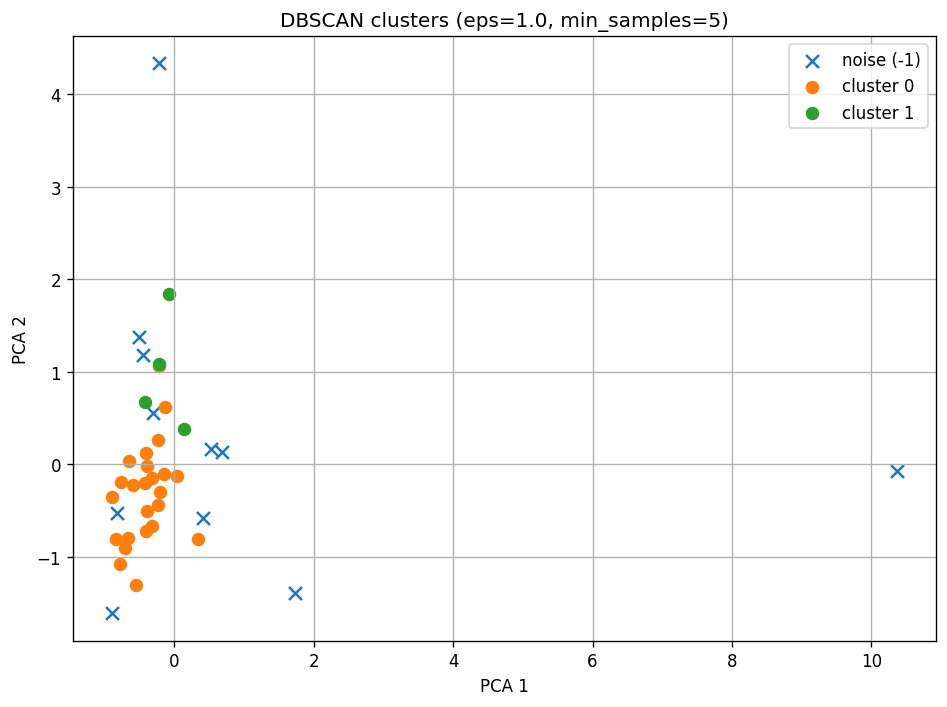

In [7]:

# Визуализация итоговых кластеров
unique_labels = sorted(set(labels_best))
palette = plt.cm.tab10(np.linspace(0,1,max(1,len(unique_labels))))

plt.figure(figsize=(8,6))
for k, col in zip(unique_labels, palette):
    mask = (labels_best == k)
    if k == -1:
        plt.scatter(X_vis[mask,0], X_vis[mask,1], marker='x', s=60, label='noise (-1)')
    else:
        plt.scatter(X_vis[mask,0], X_vis[mask,1], s=50, label=f'cluster {k}')
plt.title(f"DBSCAN clusters (eps={best_eps}, min_samples={best_ms})")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend(); plt.tight_layout(); plt.show()


## 4) Сравнение с KMeans

KMeans: k=2, silhouette=0.7724429335776172, DBI=0.14360252867050008


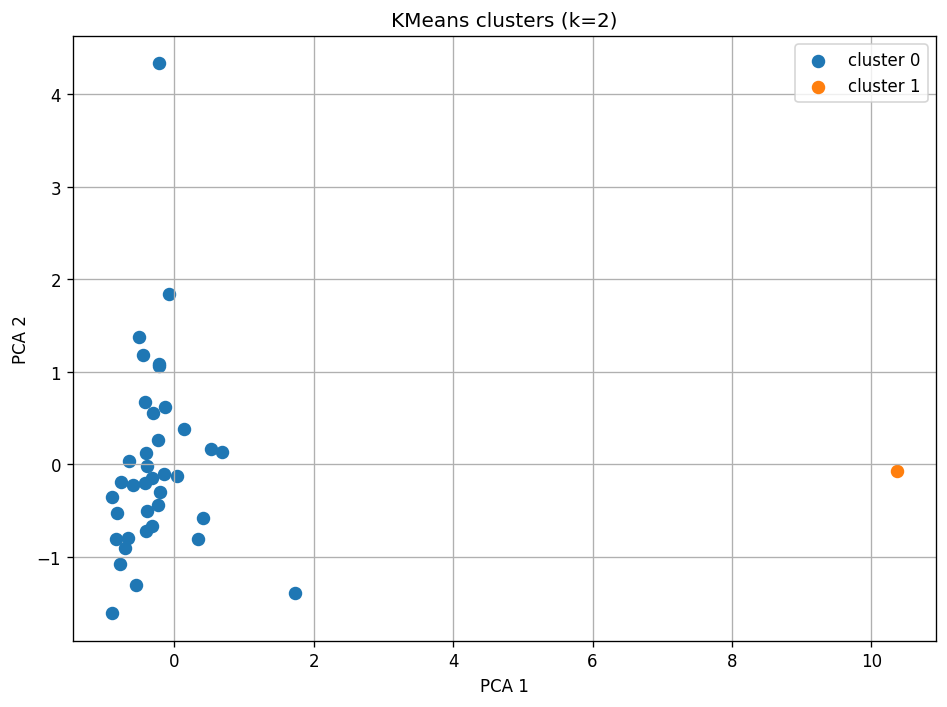

In [8]:

k = n_clusters_final if n_clusters_final >= 2 else 3
km = KMeans(n_clusters=k, n_init=10, random_state=42)
km_labels = km.fit_predict(X_scaled)

def _metric_or_nan(metric, X, labels):
    try:
        return metric(X, labels)
    except Exception:
        return np.nan

km_sil = _metric_or_nan(silhouette_score, X_scaled, km_labels) if k > 1 else np.nan
km_dbi = _metric_or_nan(davies_bouldin_score, X_scaled, km_labels) if k > 1 else np.nan
print(f"KMeans: k={k}, silhouette={km_sil}, DBI={km_dbi}")

plt.figure(figsize=(8,6))
for cl in range(k):
    mask = (km_labels == cl)
    plt.scatter(X_vis[mask,0], X_vis[mask,1], s=50, label=f'cluster {cl}')
plt.title(f"KMeans clusters (k={k})")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend(); plt.tight_layout(); plt.show()


In [9]:

# Сохранение таблиц (опционально)
res_df.to_csv("lab5_dbscan_grid_results.csv", index=False)
summary.to_csv("lab5_dbscan_best_summary.csv", index=False)
print("Saved: lab5_dbscan_grid_results.csv, lab5_dbscan_best_summary.csv")


Saved: lab5_dbscan_grid_results.csv, lab5_dbscan_best_summary.csv
